# Computer Vision 2024 Assignment 3: Deep Learning for Perception Tasks

This assignment contains 2 questions. The first question probes understanding of deep learning for classification. The second question is a more challenging classification experiment on a larger dataset. Answer the questions in separate Python notebooks.

## Question 1: A simple classifier, 20 marks

For this exercise, we provide demo code showing how to train a network on a small dataset called [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist). Please run through the code "tutorial-style" to get a sense of what it is doing. Then use the code alongside lecture notes and other resources to understand how to use pytorch libraries to implement, train and use a neural network.

For the Fashion-MNIST dataset the lables from 0-9 correspond to various clothing classes so you might find it convenient to create a python list as follows:

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

You will need to answer various questions about the system, how it operates, the results of experiments with it and make modifications to it yourself. You can change the training scheme and the network structure. 

Organize your own text and code cell to show the answer of each questions.

Detailed requirements:

In [1]:
import numpy as np # This is for mathematical operations

# this is used in plotting 
import matplotlib.pyplot as plt 
import time
import pylab as pl
from IPython import display

%matplotlib inline

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
#### Tutorial Code
####PyTorch has two primitives to work with data: torch.utils.data.DataLoader and torch.utils.data.Dataset. 
#####Dataset stores samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset.
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

# Download training data from open datasets. 
##Every TorchVision Dataset includes two arguments: 
##transform and target_transform to modify the samples and labels respectively.

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

c:\Users\linhn\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**NOTE**: For consistency with the original data set, we call our validation data "test_data". It is important to keep in mind though that we are using the data for model validation and not for testing the final, trained model (which requires data not used when training the model parameters). 

We pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset and supports automatic batching, sampling, shuffling, and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


Add in a code cell to inspect the training data, as per Q1.1. Each element of the training_data structure has a greyscale image (which you can use plt.imshow(img[0,:,:]) to display, just like you did in previous assignments.)  

### **Q1.1 (1 point)**

Extract 3 images of different types of clothing from the training dataset, print out the size/shape of the training images, and display the three with their corresponding labels. 

Image 1 size: torch.Size([1, 28, 28])
Image 2 size: torch.Size([1, 28, 28])
Image 3 size: torch.Size([1, 28, 28])


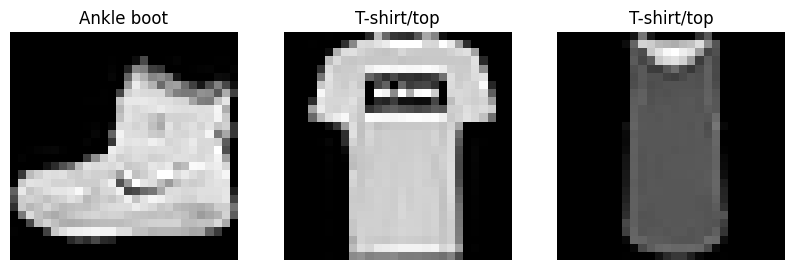

In [4]:
# Code cell for training image display

# Define class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Extract 3 images of different types of clothing from the training dataset
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, (img, label) in enumerate(training_data):
    if i >= 3:
        break
    axes[i].imshow(img[0], cmap="gray")
    axes[i].set_title(class_names[label])
    axes[i].axis('off')
    print(f"Image {i+1} size: {img.size()}")

plt.show()


**sdfg**

To define a neural network in PyTorch, we create a class that inherits from nn.Module. We define the layers of the network in the init function and specify how data will pass through the network in the forward function. To accelerate operations in the neural network, we move it to the GPU if available.

In [5]:
import random

# Set the random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

import torch.nn.functional as F

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
       )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
### Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters.

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    train_losses = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss = sum(train_losses) / len(train_losses)
    print(f"Avg train loss: {train_loss:>7f}")

    return train_loss

In [9]:
## Define a test function
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>7f} \n")
    
    return correct, test_loss

### **Q1.2 (2 points)** 

Run the training code for 10 epochs, for different values of the learning rate. Fill in the table below and plot the loss curves for each experiment:

|Lr|Accuracy|
|---|---|
|1   | 39.14%     |
|0.1|   87.74%       |
|0.01|     83.17%    |
|0.001  |        70.95%|

Loss curve is plot in the relevant code block

In [10]:
# Train and test the model
def train_test(lr, epochs=10):
    train_losses = []
    test_losses = []
    accuracy_list = []

    # set random seed
    set_seed(42)

    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        accuracy, test_loss = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracy_list.append(accuracy)

    print(f"Accuracy after {epochs} epochs: {accuracy:>6f}")
    print("Done!")

    return train_losses, test_losses, accuracy_list

In [54]:
learning_rates = [1, 0.1, 0.01, 0.001]
results = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    train_losses, test_losses, accuracy_list = train_test(lr, epochs=10)
    results[lr] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracy_list': accuracy_list
    }

Training with learning rate: 1
Epoch 1
-------------------------------
Avg train loss: 2.016069
Test Error: 
 Accuracy: 29.0%, Avg test loss: 1.637346 

Epoch 2
-------------------------------
Avg train loss: 1.598660
Test Error: 
 Accuracy: 36.5%, Avg test loss: 1.479273 

Epoch 3
-------------------------------
Avg train loss: 1.510455
Test Error: 
 Accuracy: 37.6%, Avg test loss: 1.474881 

Epoch 4
-------------------------------
Avg train loss: 1.525359
Test Error: 
 Accuracy: 37.0%, Avg test loss: 1.537592 

Epoch 5
-------------------------------
Avg train loss: 1.526206
Test Error: 
 Accuracy: 37.0%, Avg test loss: 1.481763 

Epoch 6
-------------------------------
Avg train loss: 1.501388
Test Error: 
 Accuracy: 30.6%, Avg test loss: 1.789642 

Epoch 7
-------------------------------
Avg train loss: 1.493156
Test Error: 
 Accuracy: 35.4%, Avg test loss: 1.528564 

Epoch 8
-------------------------------
Avg train loss: 1.475176
Test Error: 
 Accuracy: 38.0%, Avg test loss: 1.44

In [29]:
for lr in learning_rates:
    print(f"Accuracy after 10 epochs (learning rate {lr}): {(results[lr]['accuracy_list'][-1] * 100)}%")

Accuracy after 10 epochs (learning rate 1): 39.14%
Accuracy after 10 epochs (learning rate 0.1): 87.74%
Accuracy after 10 epochs (learning rate 0.01): 83.17%
Accuracy after 10 epochs (learning rate 0.001): 70.95%


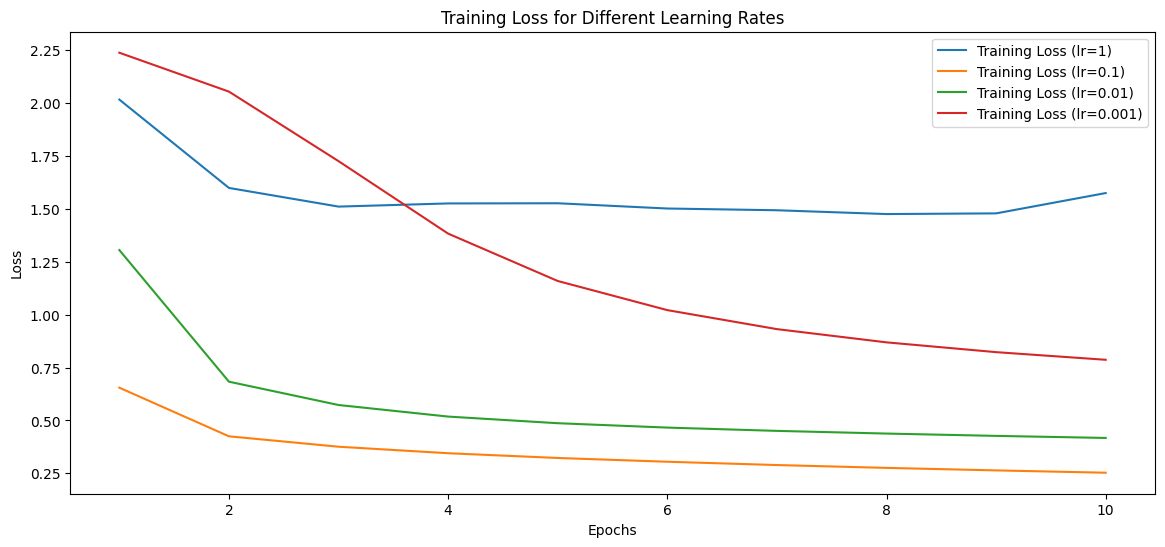

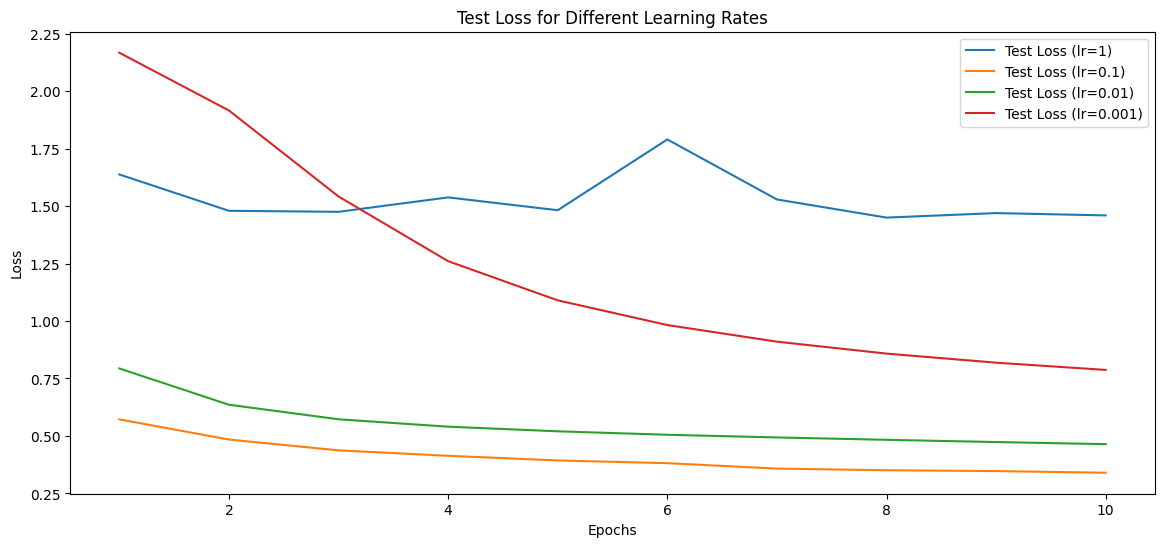

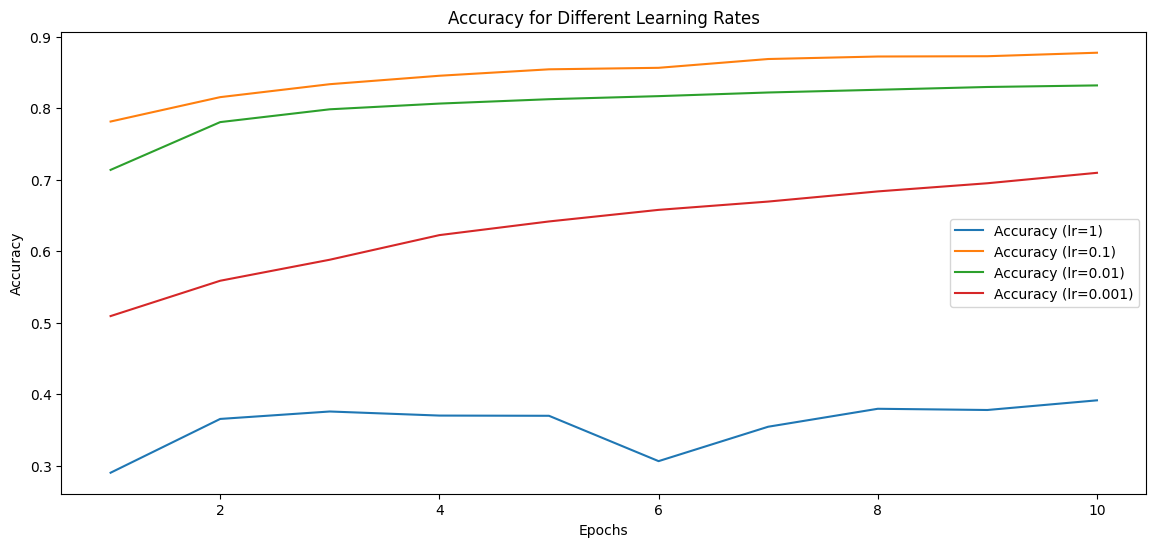

In [30]:
# Plot training loss for different learning rates
plt.figure(figsize=(14, 6))
for lr in learning_rates:
    train_losses = results[lr]['train_losses']
    plt.plot(range(1, len(train_losses) + 1), train_losses, label=f'Training Loss (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Different Learning Rates')
plt.legend()
plt.show()

# Plot test loss for different learning rates
plt.figure(figsize=(14, 6))
for lr in learning_rates:
    test_losses = results[lr]['test_losses']
    plt.plot(range(1, len(test_losses) + 1), test_losses, label=f'Test Loss (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss for Different Learning Rates')
plt.legend()
plt.show()

# Plot accuracy for different learning rates
plt.figure(figsize=(14, 6))
for lr in learning_rates:
    accuracies = results[lr]['accuracy_list']
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=f'Accuracy (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Learning Rates')
plt.legend()
plt.show()


### **Q1.3 (3 points)** 

Report the number of epochs when the accuracy reaches 85%. Fill in the table below and plot the loss curve for each experiment:

|Lr|Accuracy|Epoch|
|---|---|---|
|1   |   39.14%   |  10   |
|0.1|     85.42%     |  5  |
|0.01|    85.04%     |   16 |
|0.001  |    82.46%    |  50   |

In [31]:
def train_test_to85(lr, patience=5, max_epochs=50):
    train_losses = []
    test_losses = []
    accuracy_list = []

    best_epoch = 0

    set_seed(42)

    model = NeuralNetwork().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    t = 1
    best_accuracy = 0
    epochs_no_improve = 0

    while t <= max_epochs:
        print(f"Epoch {t}\n-------------------------------")

        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        accuracy, test_loss = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracy_list.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epoch = t
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if accuracy >= 0.85:
            print(f"Accuracy reached 85% after {t} epochs: {accuracy:>6f}")
            break

        if epochs_no_improve >= patience:
            print(f"Early stopping after {t} epochs: no improvement for {patience} epochs")
            break

        t += 1

    if accuracy < 0.85:
        print(f"Stopped after {t-1} epochs without reaching 85% accuracy. Best accuracy: {best_accuracy:>6f}")

    print("Done!")

    return train_losses, test_losses, accuracy_list, best_accuracy, best_epoch


In [32]:
learning_rates = [1, 0.1, 0.01, 0.001]
results_to85 = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    train_losses, test_losses, accuracy_list, best_accuracy, best_epoch = train_test_to85(lr)
    results_to85[lr] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracy_list': accuracy_list,
        'best_accuracy': best_accuracy,
        'best_epoch': best_epoch
    }

Training with learning rate: 1
Epoch 1
-------------------------------
Avg train loss: 2.016069
Test Error: 
 Accuracy: 29.0%, Avg test loss: 1.637346 

Epoch 2
-------------------------------
Avg train loss: 1.598660
Test Error: 
 Accuracy: 36.5%, Avg test loss: 1.479273 

Epoch 3
-------------------------------
Avg train loss: 1.510455
Test Error: 
 Accuracy: 37.6%, Avg test loss: 1.474881 

Epoch 4
-------------------------------
Avg train loss: 1.525359
Test Error: 
 Accuracy: 37.0%, Avg test loss: 1.537592 

Epoch 5
-------------------------------
Avg train loss: 1.526206
Test Error: 
 Accuracy: 37.0%, Avg test loss: 1.481763 

Epoch 6
-------------------------------
Avg train loss: 1.501388
Test Error: 
 Accuracy: 30.6%, Avg test loss: 1.789642 

Epoch 7
-------------------------------
Avg train loss: 1.493156
Test Error: 
 Accuracy: 35.4%, Avg test loss: 1.528564 

Epoch 8
-------------------------------
Avg train loss: 1.475176
Test Error: 
 Accuracy: 38.0%, Avg test loss: 1.44

In [34]:
for lr in learning_rates:
    best_accuracy = results_to85[lr]['best_accuracy']
    best_epoch = results_to85[lr]['best_epoch']
    print(f"Best Accuracy: {best_accuracy} achieved in epoch {best_epoch}")

Best Accuracy: 0.3914 achieved in epoch 10
Best Accuracy: 0.8542 achieved in epoch 5
Best Accuracy: 0.8504 achieved in epoch 16
Best Accuracy: 0.8246 achieved in epoch 50


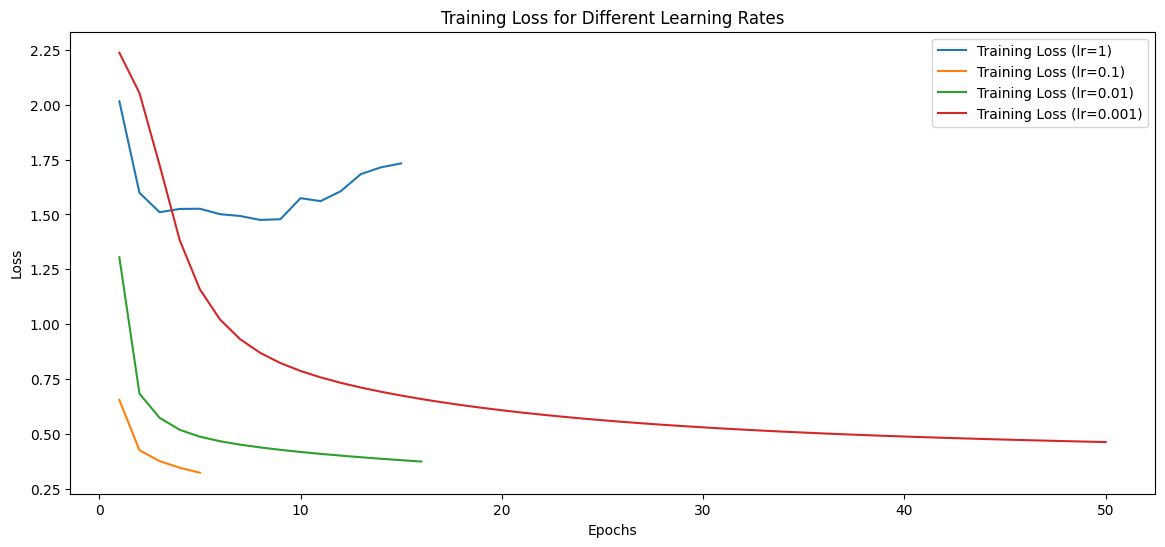

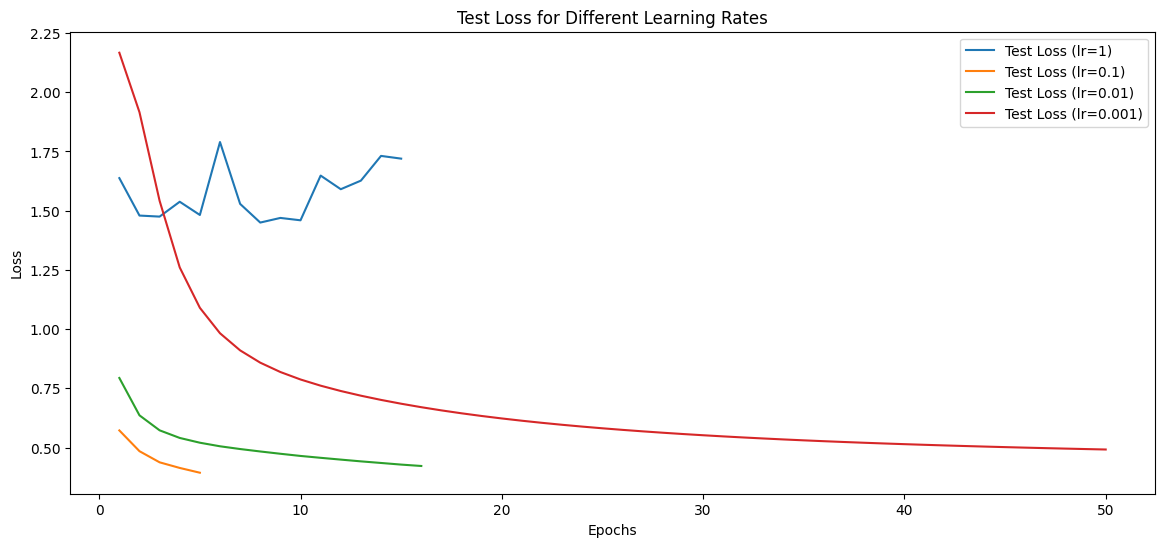

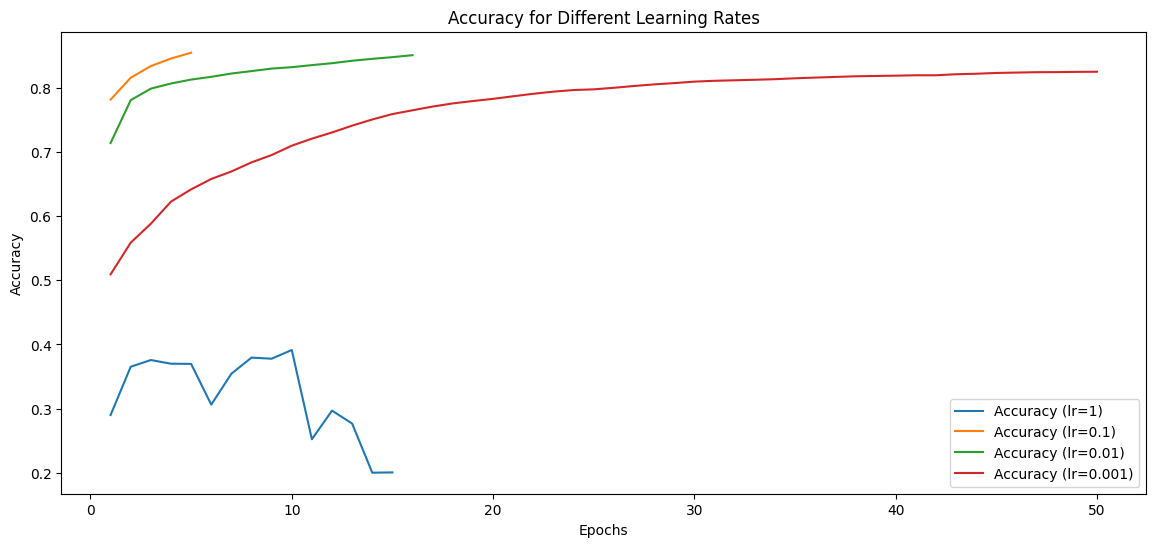

In [36]:
# Plot training loss for different learning rates
plt.figure(figsize=(14, 6))
for lr in learning_rates:
    train_losses = results_to85[lr]['train_losses']
    plt.plot(range(1, len(train_losses) + 1), train_losses, label=f'Training Loss (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Different Learning Rates')
plt.legend()
plt.show()

# Plot test loss for different learning rates
plt.figure(figsize=(14, 6))
for lr in learning_rates:
    test_losses = results_to85[lr]['test_losses']
    plt.plot(range(1, len(test_losses) + 1), test_losses, label=f'Test Loss (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss for Different Learning Rates')
plt.legend()
plt.show()

# Plot accuracy for different learning rates
plt.figure(figsize=(14, 6))
for lr in learning_rates:
    accuracies = results_to85[lr]['accuracy_list']
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=f'Accuracy (lr={lr})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Learning Rates')
plt.legend()
plt.show()


### **Q1.4 (2 points)** 

Compare the results in table 1 and table 2, what is your observation and your understanding of learning rate?

### **Q1.5 (5 points)** 

Build a wider network by modifying the code that constructs the network so that the hidden layer(s) contain more perceptrons, and record the accuracy along with the number of trainable parameters in your model.  Now modify the original network to be deeper instead of wider (i.e. by adding more hidden layers). Record your accuracy and network size findings. Plot the loss curve for each experiment. Write down your conclusions about changing the network structure?  

|Structures|Accuracy|Parameters|
|---|---|---|
|Base   | 87.74%     |669706|
|Deeper|  87.32%       |1863690|
|Wider|  87.2%      |932362|

In [37]:
# Wider model
class WiderNeuralNetwork(nn.Module):
    def __init__(self):
        super(WiderNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [38]:
# Deeper model
class DeeperNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeeperNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [39]:
# Function to count trainable parameters
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [75]:
def train_test_structures(model_name, epochs=10):
    train_losses = []
    test_losses = []
    accuracy_list = []

    # set_seed(42)

    # model = NeuralNetwork().to(device)

    # if model_name == 'wider network':
    #     model = WiderNeuralNetwork().to(device)
    # elif model_name == 'deeper network':
    #     model = DeeperNeuralNetwork().to(device)
        
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

    params = count_trainable_params(model)

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")

        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        accuracy, test_loss = test(test_dataloader, model, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracy_list.append(accuracy)

    print(f"Accuracy after {epochs} epochs: {accuracy:>6f}")
    print("Done!")

    return train_losses, test_losses, accuracy_list, params


In [76]:
models = [
    "base network",
    "wider network",
    "deeper network"
]
results_structure = {}

for model_name in models:
    print(f"Training with model: {model_name}")
    set_seed(42)
    if model_name == 'wider network':
        model = WiderNeuralNetwork().to(device)
    elif model_name == 'deeper network':
        model = DeeperNeuralNetwork().to(device)
    else:
        model = NeuralNetwork().to(device)
    train_losses, test_losses, accuracy_list, parms = train_test_structures(model, epochs=10)
    results_structure[model_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracy_list': accuracy_list,
        'parms': parms
    }

Training with model: base network
Epoch 1
-------------------------------
Avg train loss: 0.654771
Test Error: 
 Accuracy: 78.1%, Avg test loss: 0.572234 

Epoch 2
-------------------------------
Avg train loss: 0.425094
Test Error: 
 Accuracy: 81.5%, Avg test loss: 0.484538 

Epoch 3
-------------------------------
Avg train loss: 0.375857
Test Error: 
 Accuracy: 83.3%, Avg test loss: 0.437547 

Epoch 4
-------------------------------
Avg train loss: 0.345136
Test Error: 
 Accuracy: 84.5%, Avg test loss: 0.413832 

Epoch 5
-------------------------------
Avg train loss: 0.322732
Test Error: 
 Accuracy: 85.4%, Avg test loss: 0.393653 

Epoch 6
-------------------------------
Avg train loss: 0.304913
Test Error: 
 Accuracy: 85.6%, Avg test loss: 0.381751 

Epoch 7
-------------------------------
Avg train loss: 0.289303
Test Error: 
 Accuracy: 86.9%, Avg test loss: 0.358126 

Epoch 8
-------------------------------
Avg train loss: 0.275900
Test Error: 
 Accuracy: 87.2%, Avg test loss: 0

In [80]:
for model in models:
    accuracy = results_structure[model]['accuracy_list'][-1]
    parms = results_structure[model]['parms']
    print(f"Model: {model}, number of trainable parameters: {parms}")
    print(f"Accuracy after 10 epochs : {accuracy*100}%\n")

Model: base network, number of trainable parameters: 669706
Accuracy after 10 epochs : 87.74%

Model: wider network, number of trainable parameters: 1863690
Accuracy after 10 epochs : 87.32%

Model: deeper network, number of trainable parameters: 932362
Accuracy after 10 epochs : 87.2%



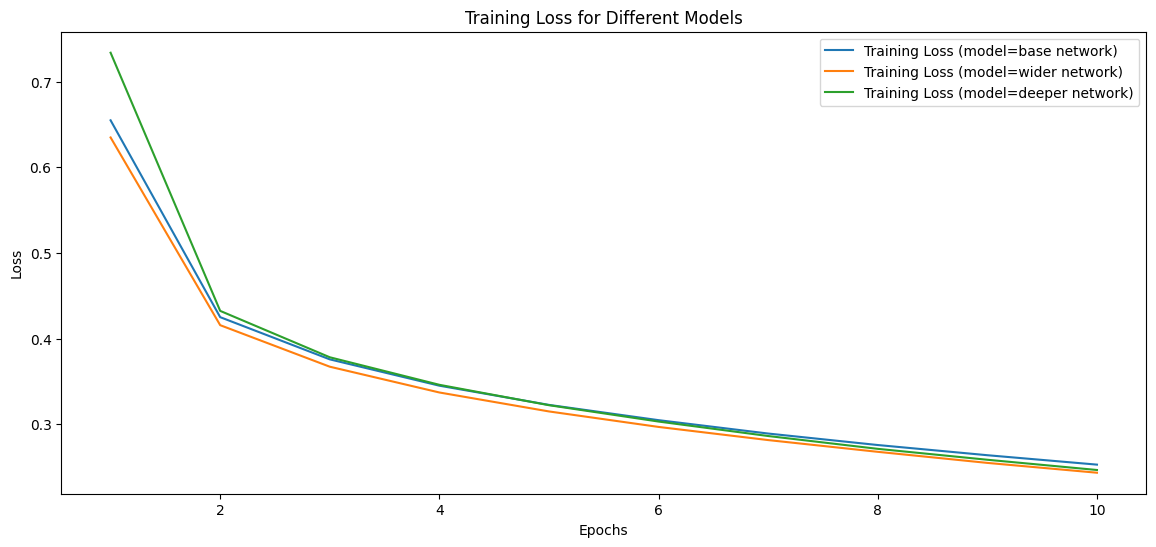

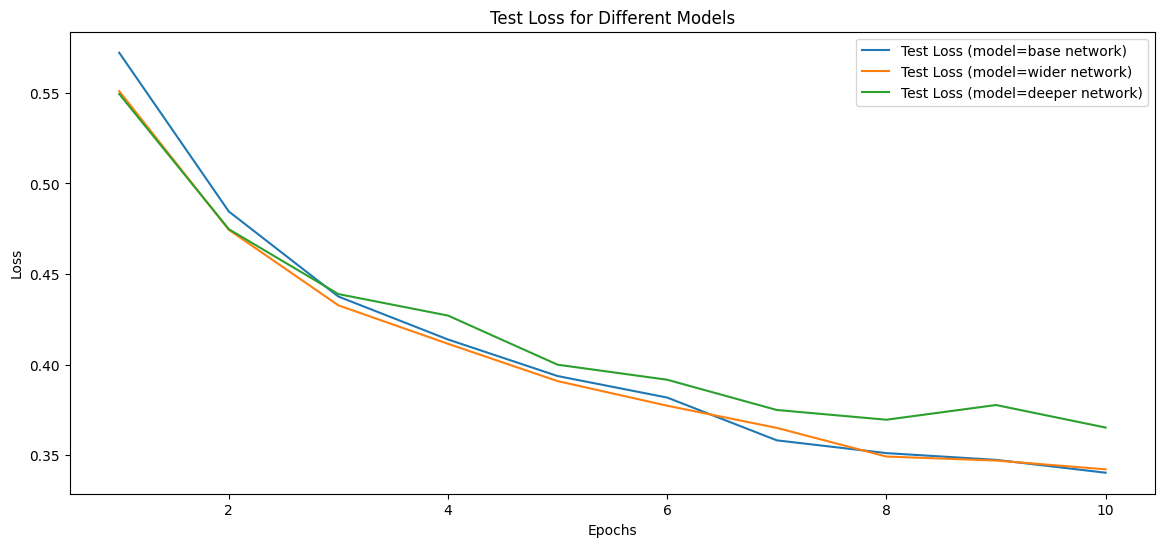

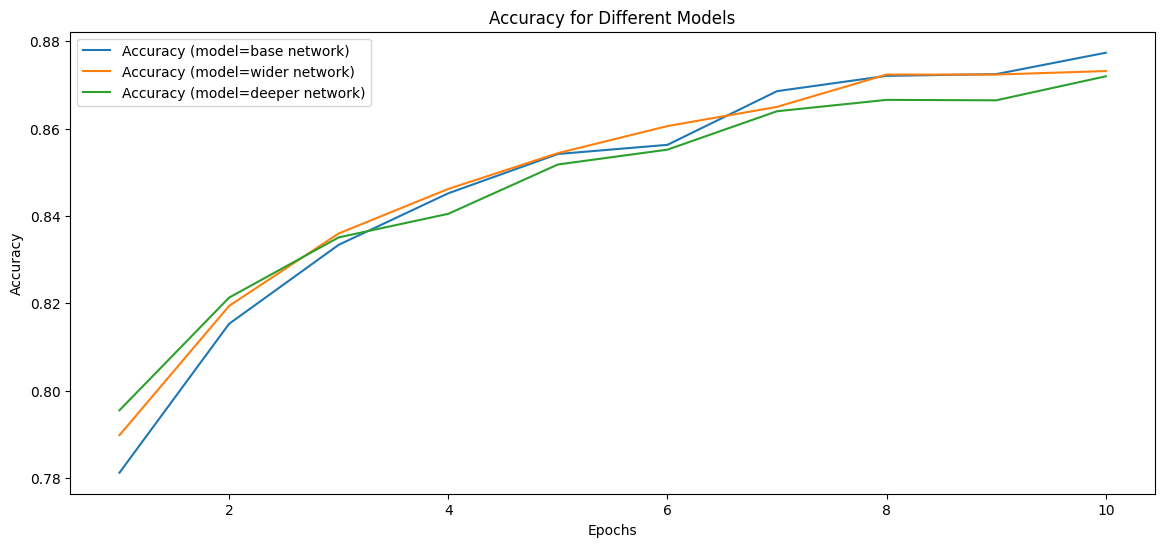

In [77]:
# Plot training loss for different models
plt.figure(figsize=(14, 6))
for model_name in models:
    train_losses = results_structure[model_name]['train_losses']
    plt.plot(range(1, len(train_losses) + 1), train_losses, label=f'Training Loss (model={model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Different Models')
plt.legend()
plt.show()

# Plot test loss for different models
plt.figure(figsize=(14, 6))
for model_name in models:
    test_losses = results_structure[model_name]['test_losses']
    plt.plot(range(1, len(test_losses) + 1), test_losses, label=f'Test Loss (model={model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Test Loss for Different Models')
plt.legend()
plt.show()

# Plot accuracy for different models
plt.figure(figsize=(14, 6))
for model_name in models:
    accuracy_list = results_structure[model_name]['accuracy_list']
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, label=f'Accuracy (model={model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Models')
plt.legend()
plt.show()

### **Q1.6 (2 points)** 

Calculate the mean of the gradients of the loss to all trainable parameters. Plot the gradients curve for the first 100 training steps. What are your observations? Note that this gradients will be saved with the training weight automatically after you call loss.backwards(). Hint: the mean of the gradients decrease.

For more exlanation of q1.6, you could refer to the following simple instructions: https://colab.research.google.com/drive/1XAsyNegGSvMf3_B6MrsXht7-fHqtJ7OW?usp=sharing

In [115]:
# Define the training function with gradient tracking
def train_tracking_gradient(dataloader, model, loss_fn, optimizer, steps=100):
    size = len(dataloader.dataset)
    model.train()

    mean_gradients = []
    
    for step, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_gradients = 0
        num_params = 0
        for param in model.parameters():
            if param.grad is not None:
                total_gradients += param.grad.sum().item()
                num_params += param.grad.numel()

        mean_gradient = total_gradients / num_params if num_params > 0 else 0
        mean_gradients.append(mean_gradient)

        # # Print the mean gradient for the current step
        # print(f"Step {step + 1}, Mean Gradient: {mean_gradient}")

        if step >= steps - 1:
            break

    return mean_gradients

In [123]:
# set random seed
set_seed(42)

model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)# Define loss function and optimizer

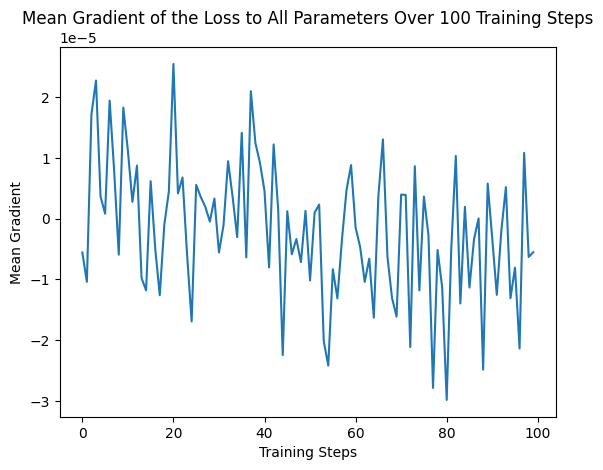

In [124]:
# Train the model and track gradients
mean_gradients = train_tracking_gradient(train_dataloader, model, loss_fn, optimizer, 100)

# Plot the mean gradients
plt.plot(mean_gradients)
plt.xlabel('Training Steps')
plt.ylabel('Mean Gradient')
plt.title('Mean Gradient of the Loss to All Parameters Over 100 Training Steps')
plt.show()

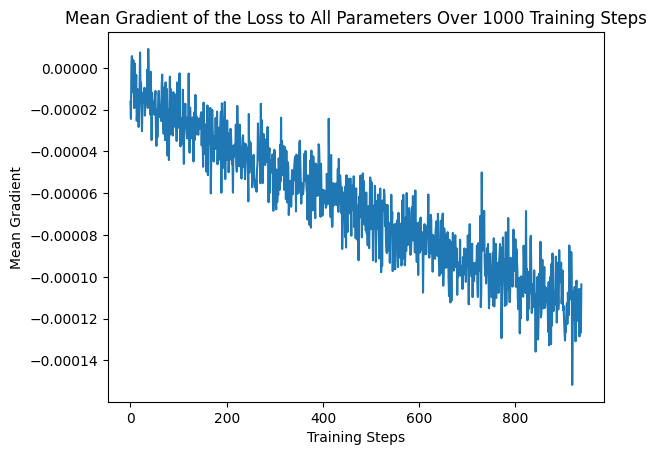

In [125]:
# Train the model and track gradients
mean_gradients = train_tracking_gradient(train_dataloader, model, loss_fn, optimizer, 1000)

# Plot the mean gradients
plt.plot(mean_gradients)
plt.xlabel('Training Steps')
plt.ylabel('Mean Gradient')
plt.title('Mean Gradient of the Loss to All Parameters Over 1000 Training Steps')
plt.show()

### **Q1.7 (5 points)** 

Modify the network structure and training/test to use a small convolutional neural network instead of an MLP. Discuss your findings with regard to convergence, accuracy and number of parameters, relative to MLPs.  

Hint: Look at the structure of the CNN in the Workshop 3 examples.

In [119]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # First convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # First pooling layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Second convolutional layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)   # Second pooling layer
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32 * 7 * 7, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [128]:
# Function to train and test different network architectures
def experiment_with_cnn(lr=0.1, epochs=10):
    set_seed(42)
    model = CNN().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    accuracies = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        accuracy, test_loss = test(test_dataloader, model, loss_fn)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        accuracies.append(accuracy)
    params = sum(p.numel() for p in model.parameters())
    print(f"CNN network, Accuracy: {accuracy:.4f}, Parameters: {params}")
    return train_losses, test_losses, accuracies

In [130]:
epochs = 15

print("Training CNN:")
cnn_train_losses, cnn_test_losses, cnn_accuracies = experiment_with_cnn(lr=0.1, epochs=epochs)
print("\nTrain NN")
nn_train_losses, nn_test_losses, nn_accuracies = train_test(lr=0.1, epochs=epochs)

Training CNN:
Epoch 1
-------------------------------
Avg train loss: 0.688765
Test Error: 
 Accuracy: 80.1%, Avg test loss: 0.515293 

Epoch 2
-------------------------------
Avg train loss: 0.395178
Test Error: 
 Accuracy: 84.4%, Avg test loss: 0.415526 

Epoch 3
-------------------------------
Avg train loss: 0.337091
Test Error: 
 Accuracy: 86.8%, Avg test loss: 0.351734 

Epoch 4
-------------------------------
Avg train loss: 0.303980
Test Error: 
 Accuracy: 87.8%, Avg test loss: 0.326692 

Epoch 5
-------------------------------
Avg train loss: 0.280379
Test Error: 
 Accuracy: 88.7%, Avg test loss: 0.310187 

Epoch 6
-------------------------------
Avg train loss: 0.260980
Test Error: 
 Accuracy: 89.1%, Avg test loss: 0.297129 

Epoch 7
-------------------------------
Avg train loss: 0.244924
Test Error: 
 Accuracy: 89.4%, Avg test loss: 0.286359 

Epoch 8
-------------------------------
Avg train loss: 0.230290
Test Error: 
 Accuracy: 89.9%, Avg test loss: 0.278235 

Epoch 9
--

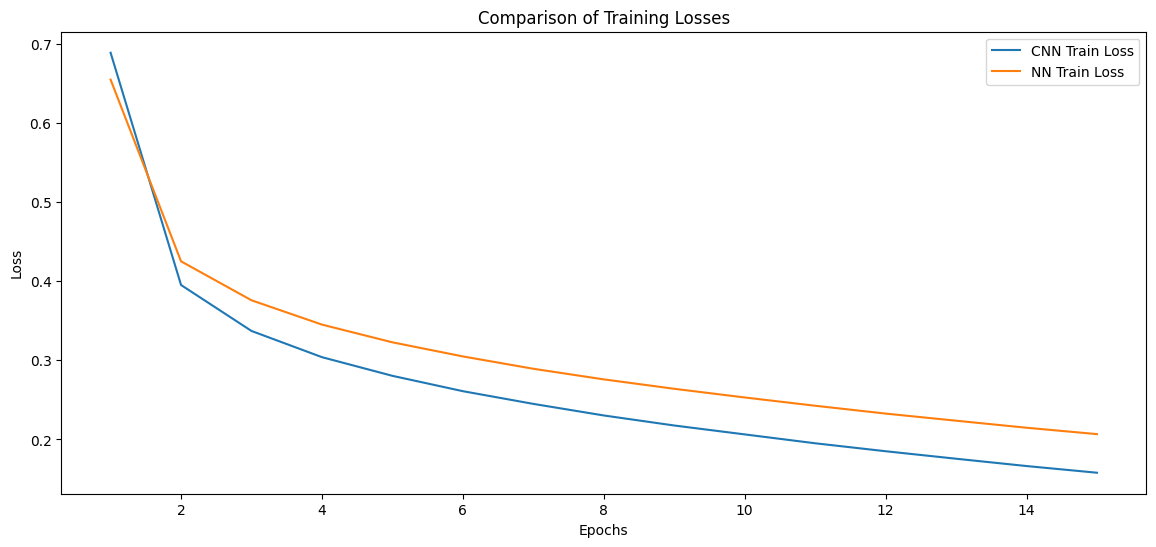

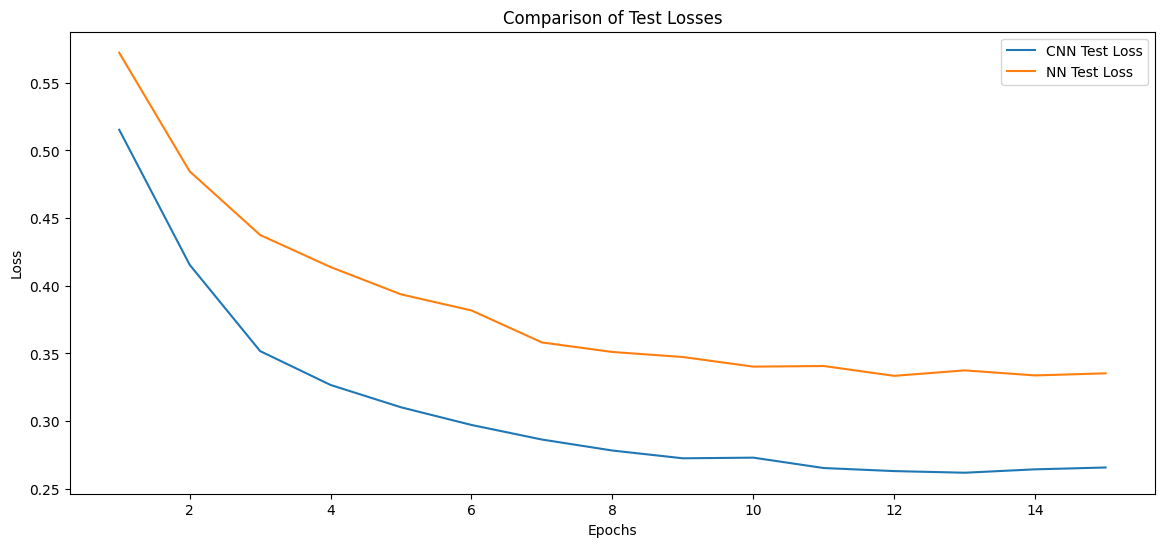

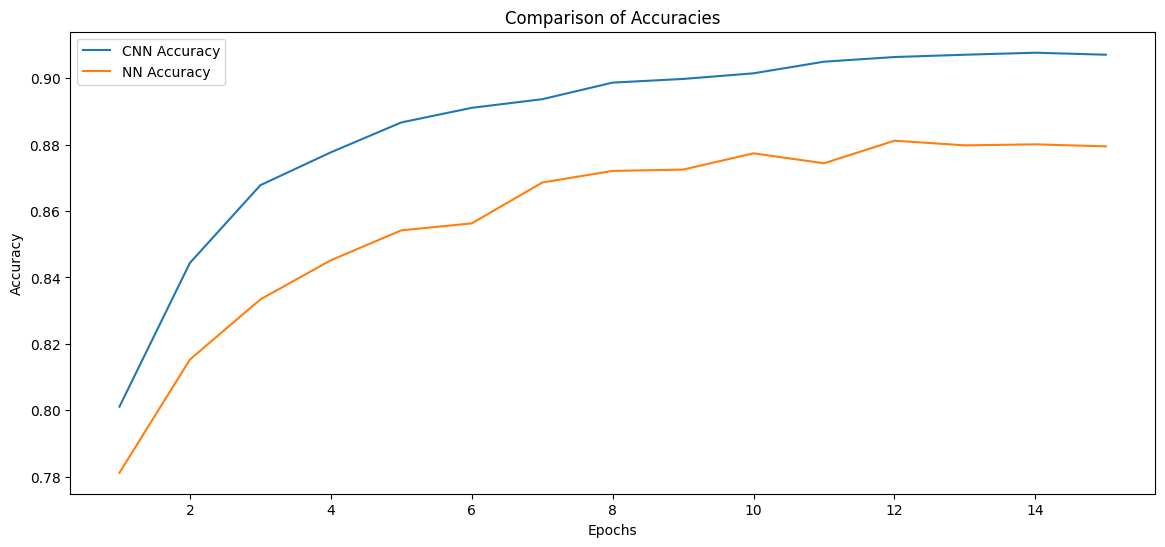

In [136]:
# Plot the comparison curves
x_epochs = range(1, epochs + 1)

# Plot loss curves
plt.figure(figsize=(14, 6))
plt.plot(x_epochs, cnn_train_losses, label='CNN Train Loss')
plt.plot(x_epochs, nn_train_losses, label='NN Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Training Losses')
plt.legend()

# Plot loss curves
plt.figure(figsize=(14, 6))
plt.plot(x_epochs, cnn_test_losses, label='CNN Test Loss')
plt.plot(x_epochs, nn_test_losses, label='NN Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Test Losses')
plt.legend()

# Plot accuracy curves
plt.figure(figsize=(14, 6))
plt.plot(x_epochs, cnn_accuracies, label='CNN Accuracy')
plt.plot(x_epochs, nn_accuracies, label='NN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracies')
plt.legend()

plt.show()